# Context
Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984. A description of the clinical background for the trial and the covariates recorded here is in Chapter 0, especially Section 0.2 of Fleming and Harrington, Counting
Processes and Survival Analysis, Wiley, 1991. A more extended discussion can be found in Dickson, et al., Hepatology 10:1-7 (1989) and in Markus, et al., N Eng J of Med 320:1709-13 (1989).

A total of 424 PBC patients, referred to Mayo Clinic during that ten-year interval, met eligibility criteria for the randomized placebo-controlled trial of the drug D-penicillamine. The first 312 cases in the dataset participated in the randomized trial and contain largely complete data. The additional 112 cases did not participate in the clinical trial but consented to have basic measurements recorded and to be followed for survival. Six of those cases were lost to follow-up shortly after diagnosis, so the data here are on an additional 106 cases as well as the 312 randomized participants.

Attribute Information
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

# Project 4 - Part 2 (Core):


## Task:

- Choose at least one feature selection or feature engineering method to apply to the data and compare the models’  performance with and without feature selection/engineering.
    - Some options include:
        - Apply PCA  to keep .85 variance ratio 
        - Apply PCA to get 3 principal components for the data. Concatenate/combine these PC’s with the original features (X_train, X_test data).
        - Apply Clustering, select the appropriate number of clusters, and use the clustering object to get predicted clusters for the training and test data. Concatenate/combine these clusters with the original features. 
        - Create additional features by applying the feature engineering techniques demoed on the LP.
    - Fit and evaluate a model using your updated/expanded features and compare it to your model from Part 1.
    - Apply at least one method of feature selection (filtering, embedded, wrapper).
    - Fit and evaluate a final model using the selected features.
        - Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4). 
        - In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

# Load Data

In [3]:
fpath="Data/archive (2).zip"
df=pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## Explore and Clean Data
- Drop ID column
- Checking for NA values
    - 106 cases did not particapate in the study but consented to have basic measurements recorded and to be followed for survival
        - Are these cases useful?
- .describe() on numerical data to find outliers
- Identify columns that have binary values
    - Address these columns

In [4]:
del df['ID']
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

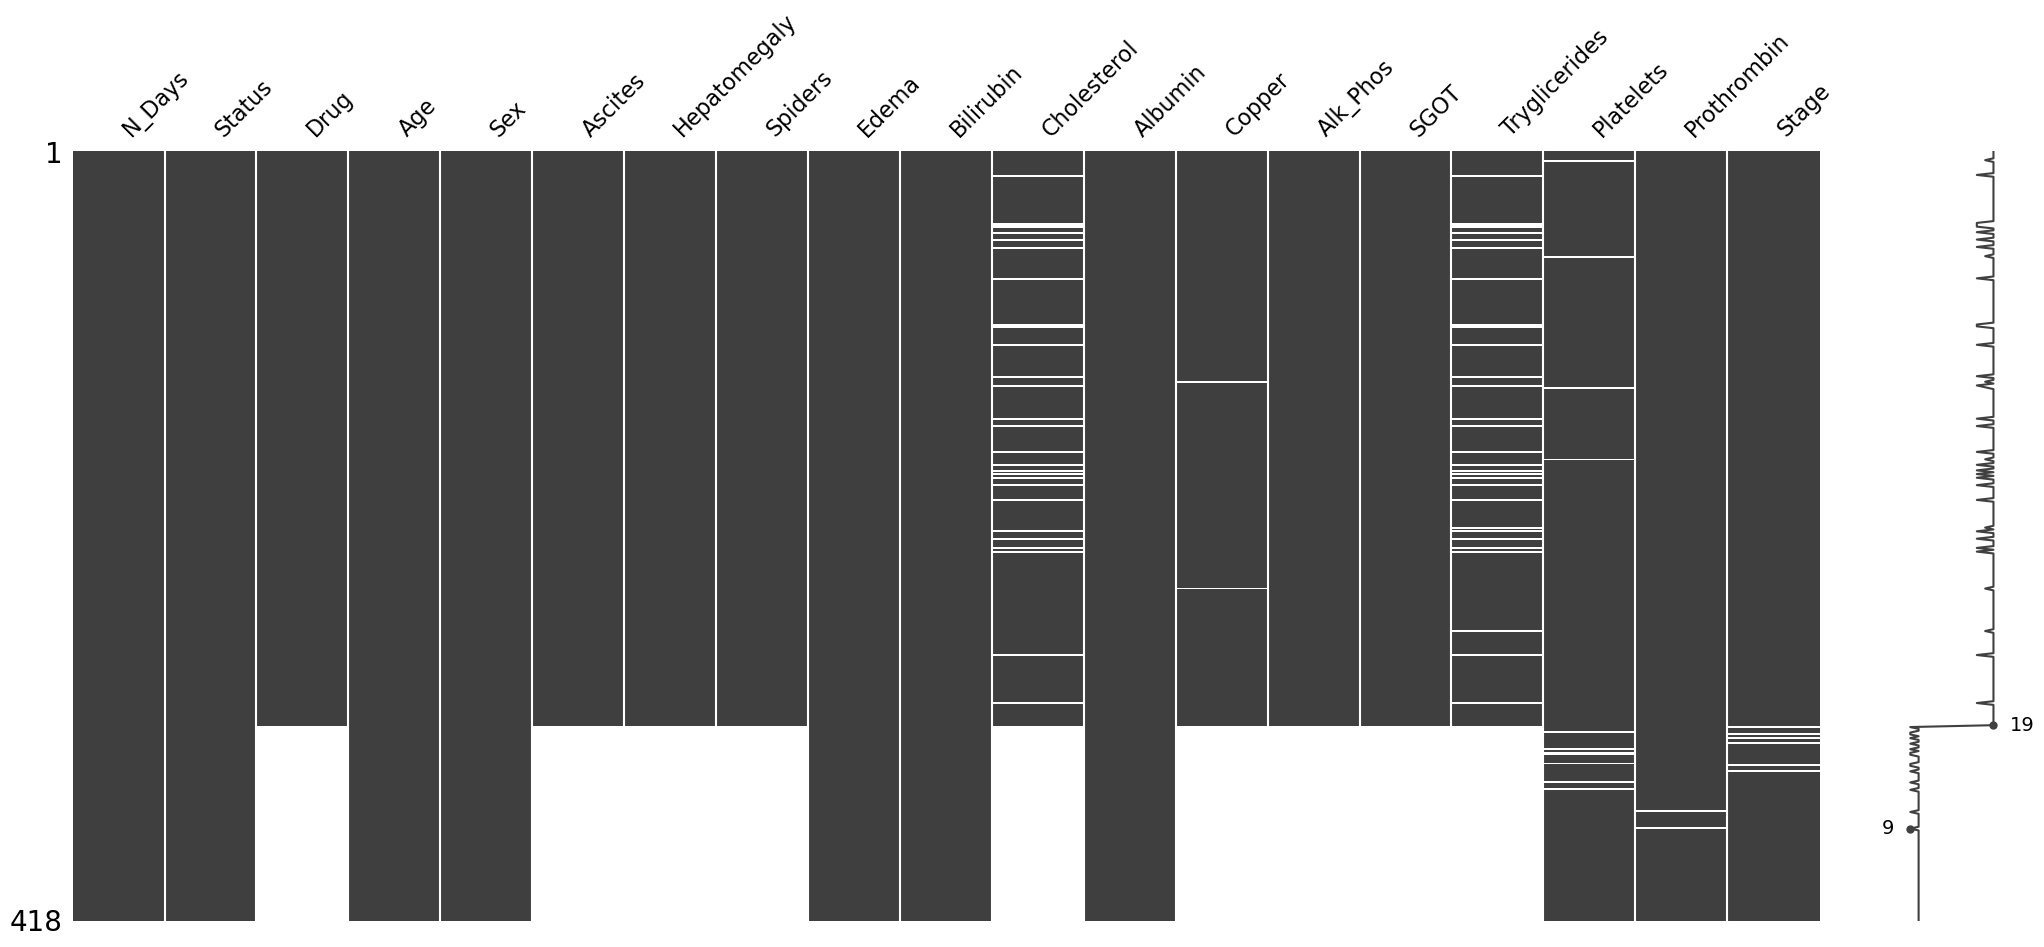

In [6]:
missingno.matrix(df);

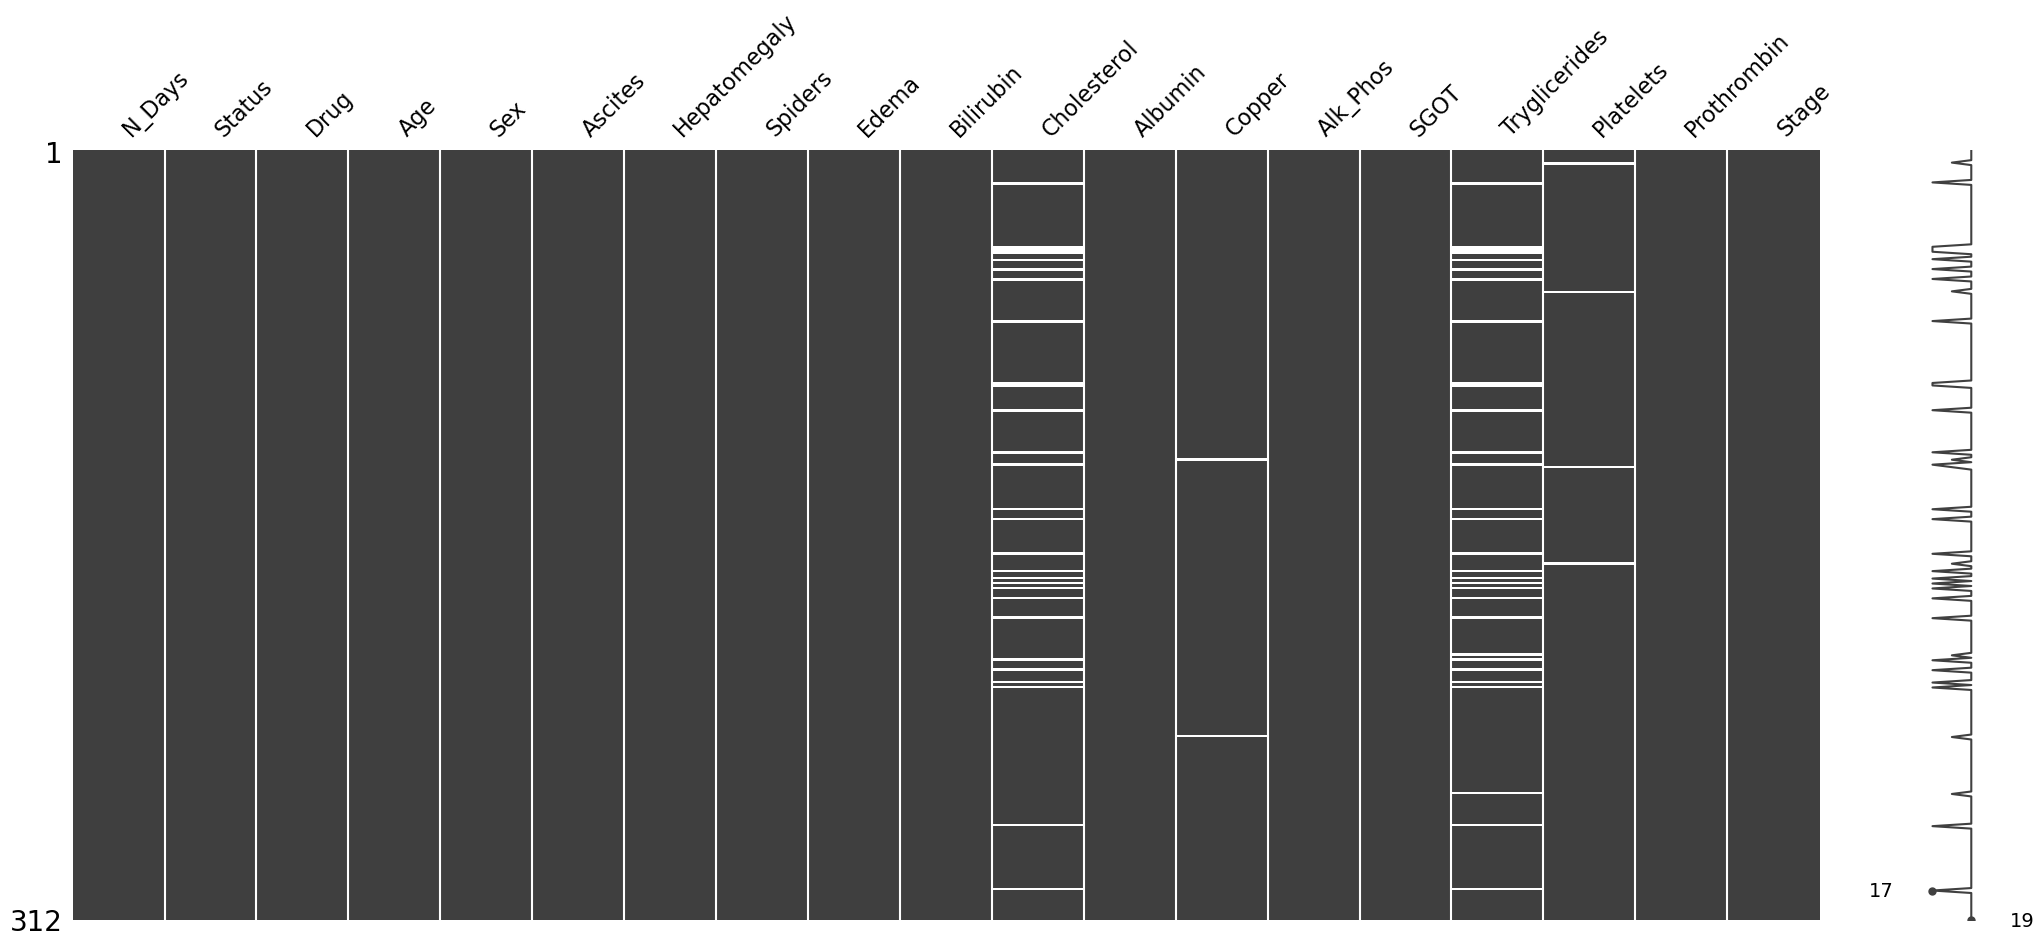

In [7]:
df=df.dropna(subset=['Drug'])
missingno.matrix(df);

Changing Status and Edema to a numeric binary column

In [8]:
df['Status'] = df['Status'].replace({'C':1,'CL':1,"D":0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Decided to change everything to an numeric type

In [9]:
df['Edema'] = df['Edema'].replace({'N':0,'S':0,'Y':1})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,D-penicillamine,21464,F,Y,Y,Y,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,D-penicillamine,20617,F,N,Y,Y,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,D-penicillamine,25594,M,N,N,N,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,D-penicillamine,19994,F,N,Y,Y,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,Placebo,13918,F,N,Y,Y,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [10]:
df = df.replace({'F':0,'M':1,'D-penicillamine':1,'Placebo':0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,21464,0,Y,Y,Y,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,1,20617,0,N,Y,Y,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,1,25594,1,N,N,N,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,1,19994,0,N,Y,Y,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,0,13918,0,N,Y,Y,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [11]:
yn_col=['Ascites','Hepatomegaly','Spiders']
df[yn_col] = df[yn_col].replace({'Y':1,"N":0})
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,21464,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,1,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,1,25594,1,0,0,0,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,1,19994,0,0,1,1,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,0,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Changing Age to year rather then days

In [12]:
df['Age']=df['Age']//360
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,59,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,1,1,57,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,0,1,71,1,0,0,0,0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,0,1,55,0,0,1,1,0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,0,38,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Ajusting columns with outlires with np.log

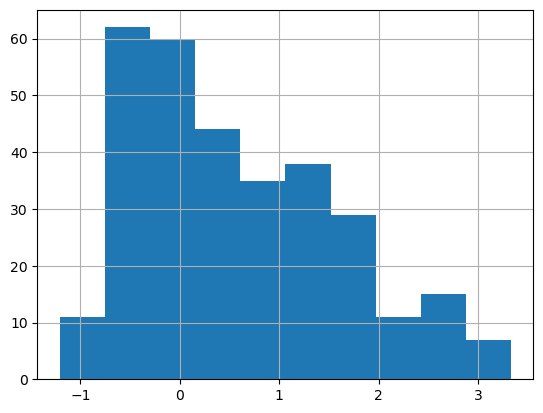

In [13]:
outlires = ['Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Prothrombin']
df[outlires] = np.log(df[outlires])
df['Bilirubin'].hist();

Looking over all changes

In [14]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,0,1,59,0,1,1,1,1,2.674149,5.564520,2.60,5.049856,7.448916,4.926891,5.147494,190.0,2.501436,4.0
1,4500,1,1,57,0,0,1,1,0,0.095310,5.710427,4.14,3.988984,8.908532,4.731979,4.477337,221.0,2.360854,3.0
2,1012,0,1,71,1,0,0,0,0,0.336472,5.170484,3.48,5.347108,6.246107,4.565389,4.007333,151.0,2.484907,4.0
3,1925,0,1,55,0,0,1,1,0,0.587787,5.497168,2.54,4.158883,8.719611,4.104790,4.521789,183.0,2.332144,4.0
4,1504,1,0,38,0,0,1,1,0,1.223775,5.631212,3.53,4.962845,6.508769,4.728714,4.276666,136.0,2.388763,3.0


In [15]:
df.isna().sum()

N_Days            0
Status            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
dtype: int64

# TTS
- Decided to remove other possible targets

In [16]:
possible_targets = ['Stage', 'Drug']
target = ['Status']
y=df[target].copy()
X=df.drop(columns=[*target, *possible_targets])
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
X_train.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
119,2033,35,1,0,0,0,0,1.252763,5.783825,3.98,6.095825,6.641182,4.869072,5.347108,344.0,2.360854
258,1615,60,0,0,1,0,0,1.131402,5.624018,2.97,3.737670,7.012115,4.828314,4.836282,221.0,2.282382
244,1790,46,0,0,1,0,0,-0.510826,5.609472,3.65,3.871201,6.677083,3.964615,5.365976,305.0,2.261763
204,2081,49,0,1,0,0,0,0.916291,5.945421,3.55,4.682131,7.323831,5.475208,NaN,126.0,2.332144
137,1297,51,1,0,1,0,0,1.987874,6.054439,3.93,5.568345,7.793174,4.981550,5.384495,252.0,2.351375


In [17]:
df[target].value_counts(normalize=True)

Status
1         0.599359
0         0.400641
dtype: float64

Made all columns numeric for simplicity
- using Random Forest Classifier
- Basic model

In [18]:
num_cols = X_train.select_dtypes('number').columns
print('\n -', num_cols)
impute_median = SimpleImputer(strategy = 'median')
scaler = StandardScaler()
smote = SMOTE()
rf = RandomForestClassifier(random_state=45)

#pipeline
rf_pipe = make_pipeline(impute_median,scaler,smote,rf)


 - Index(['N_Days', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin'],
      dtype='object')


In [19]:
rf_pipe.fit(X_train,y_train)
rf_pipe.score(X_test,y_test)


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


0.7692307692307693

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00       141

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234



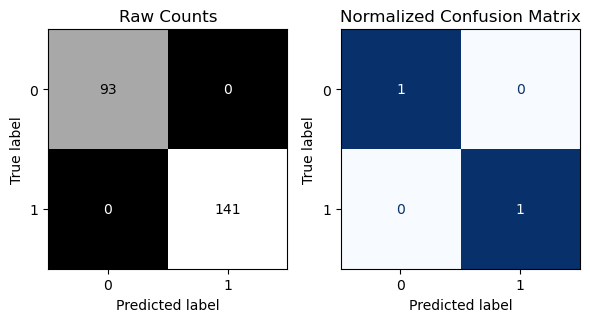


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        32
           1       0.79      0.83      0.81        46

    accuracy                           0.77        78
   macro avg       0.76      0.76      0.76        78
weighted avg       0.77      0.77      0.77        78



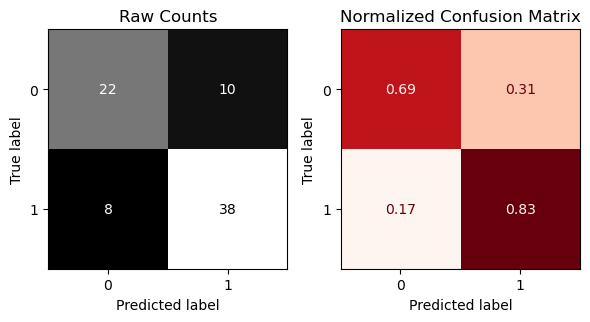

In [20]:
evaluate_classification(rf_pipe,X_train,y_train,X_test,y_test)

## Basic model
- On test data
    - 77% Accuracy
    - 72% precision for class 0 and 80% precision for class 1
    - 72% recall for class 0 and 80% recall for class 1

In [21]:
pca = PCA(n_components = .85)
preprocessor = make_pipeline(impute_median,scaler)
pca_pre = make_pipeline(impute_median,scaler, pca)
pca_sm_pipe = make_pipeline(impute_median,scaler, smote, pca) 
sm_pre = make_pipeline(impute_median,scaler, smote)

In [22]:
pca_sm_pipe.fit_transform(X_train,y_train)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,0.056711,-1.737544,2.244152,0.979960,1.547008,-0.002374,0.090107,1.853560,-1.657953,0.050656
1,0.202999,0.459396,0.080791,-0.107996,-0.988159,-1.550173,0.330922,-1.336404,0.265978,-0.184981
2,-1.611879,0.239730,-0.009047,-0.848034,-1.529227,-1.442268,0.879186,0.761300,-1.094054,0.590570
3,1.251471,0.327378,-0.107125,-0.649476,2.246207,-0.649661,1.459690,-0.478712,0.228620,-0.620030
4,1.585995,-1.921512,2.747448,0.895324,-0.084997,-0.041120,0.746572,0.558263,-0.762374,0.532856
...,...,...,...,...,...,...,...,...,...,...
277,5.757165,2.221394,-1.003392,-1.130666,1.532725,0.718700,0.942092,0.893485,-0.370135,-0.053550
278,-3.299105,2.173282,-0.351734,-0.921058,-0.316824,0.170575,-0.443376,-0.185654,-0.169844,-0.251696
279,-0.904067,-1.616768,-0.363774,0.160905,1.761632,-0.094213,-0.842406,0.195194,0.449361,0.390119
280,1.906144,1.224414,-0.895401,2.371505,-0.931949,0.409296,0.077971,0.732563,1.234587,-0.514196


In [23]:
sm_pipe = make_pipeline(impute_median,scaler,smote,pca,rf)
sm_pipe.fit(X_train,y_train)
sm_pipe.score(X_test,y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/imblearn/pipeline.py:297: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


0.8461538461538461

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00       141

    accuracy                           1.00       234
   macro avg       1.00      1.00      1.00       234
weighted avg       1.00      1.00      1.00       234



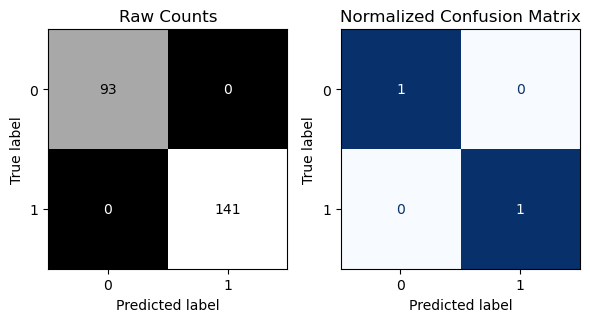


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.85      0.89      0.87        46

    accuracy                           0.85        78
   macro avg       0.84      0.84      0.84        78
weighted avg       0.85      0.85      0.85        78



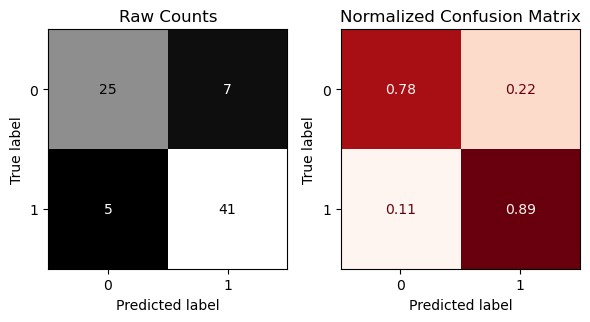

In [24]:
evaluate_classification(sm_pipe,X_train,y_train,X_test,y_test)

## 85% PCA
- on test data
    - 82% Accuracy, improvment
    - 76% precision for class 0 and 86% precision for class 1
    - 81% recall for class 0 and 83% recall for class 1 
        - improvments

# Trying to use pc's as columns

preprocessor = make_pipeline(impute_median,scaler)
pca_pre = make_pipeline(impute_median,scaler, pca)
pca_sm_pipe = make_pipeline(impute_median,scaler, smote, pca) 
sm_pre = make_pipeline(impute_median,scaler, smote)

In [29]:
X_train_tf, y_train_tf = sm_pre.fit_resample(X_train,y_train)
X_test_tf = preprocessor.transform(X_test)

In [30]:
pca3 = PCA(n_components=3)
X_train_pca = pca3.fit_transform(X_train_tf)
X_test_pca = pca3.transform(X_test_tf)
X_train_pca.head()

,pca0,pca1,pca2
0,-0.099615,-1.999022,1.938339
1,0.182183,0.477898,0.074483
2,-1.598484,0.324603,-0.158145
3,1.180109,0.384975,-0.059642
4,1.322881,-2.405092,2.363000


In [31]:
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)
X_train_pca_scaled.head()

,pca0,pca1,pca2
0,-0.048681,-1.313011,1.567829
1,0.089031,0.313896,0.060245
2,-0.781168,0.213208,-0.127916
3,0.576710,0.252862,-0.048242
4,0.646482,-1.579728,1.911317


In [32]:
X_train_con_pca = pd.concat([X_train_tf, X_train_pca_scaled], axis=1)
X_test_con_pca = pd.concat([X_test_tf, X_test_pca_scaled], axis = 1)
X_train_con_pca.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,pca0,pca1,pca2
0,0.023190,-1.383332,2.658753,-0.305709,-0.949968,-0.600387,-0.270914,0.695727,-0.051676,1.057583,2.222362,-0.851269,0.386937,1.475673,0.831508,-0.120064,-0.048681,-1.313011,1.567829
1,-0.348777,0.911759,-0.376116,-0.305709,1.052667,-0.600387,-0.270914,0.576845,-0.433910,-1.299316,-0.628447,-0.342292,0.294324,0.266714,-0.443938,-0.994665,0.089031,0.313896,0.060245
2,-0.193049,-0.373492,-0.376116,-0.305709,1.052667,-0.600387,-0.270914,-1.031843,-0.468702,0.287507,-0.467019,-0.802007,-1.668241,1.520329,0.427098,-1.224476,-0.781168,0.213208,-0.127916
3,0.065904,-0.098081,-0.376116,3.271085,-0.949968,-0.600387,-0.270914,0.366127,0.334835,0.054151,0.513327,0.085429,1.764247,-0.033266,-1.429038,-0.440051,0.576710,0.252862,-0.048242
4,-0.631756,0.085526,2.658753,-0.305709,1.052667,-0.600387,-0.270914,1.415825,0.595591,0.940905,1.584683,0.729440,0.642519,1.564157,-0.122484,-0.225709,0.646482,-1.579728,1.911317


In [33]:
X_test_con_pca.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,pca0,pca1,pca2
228,-1.476244,1.187170,-0.376116,3.271085,1.052667,-0.600387,-0.270914,0.941909,-1.323064,-1.112631,1.258244,-0.458318,1.060830,0.111467,-1.294235,0.690871,1.470235,1.213782,0.558492
9,-1.740536,1.921599,-0.376116,3.271085,-0.949968,1.665591,3.691206,1.950500,-1.212934,-1.836036,0.827054,-0.602889,0.666564,0.566247,0.395990,0.788212,2.243177,2.023420,0.303884
57,2.182019,-0.465295,2.658753,-0.305709,-0.949968,-0.600387,-0.270914,-0.880840,-0.757000,1.290940,0.039829,1.947687,-1.499600,0.111467,-0.018789,-0.120064,-1.182843,-0.426916,1.785868
60,2.001375,-0.557099,2.658753,-0.305709,-0.949968,-0.600387,-0.270914,-1.031843,-1.028855,0.964241,-1.118620,-1.184136,-1.356481,1.213764,-0.547632,2.154669,-0.981721,0.736229,1.448264
25,-0.500945,0.177330,-0.376116,-0.305709,1.052667,1.665591,-0.270914,1.083538,2.924677,0.357514,-0.347226,1.122484,0.936856,0.919221,1.629957,-0.881513,0.463856,-1.994312,-0.910589


In [34]:
rf.fit(X_train_con_pca,y_train_tf)
rf.score(X_test_pca_scaled,y_test)

/var/folders/zd/1wqdzm7d7d13shmcygx_4src0000gn/T/ipykernel_1457/3618331933.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_con_pca,y_train_tf)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Age
- Albumin
- Alk_Phos
- Ascites
- Bilirubin
- ...


In [ ]:
evaluate_classification(rf,X_train_con_pca,y_train_tf,X_test_pca_scaled,y_test)

# Filtering

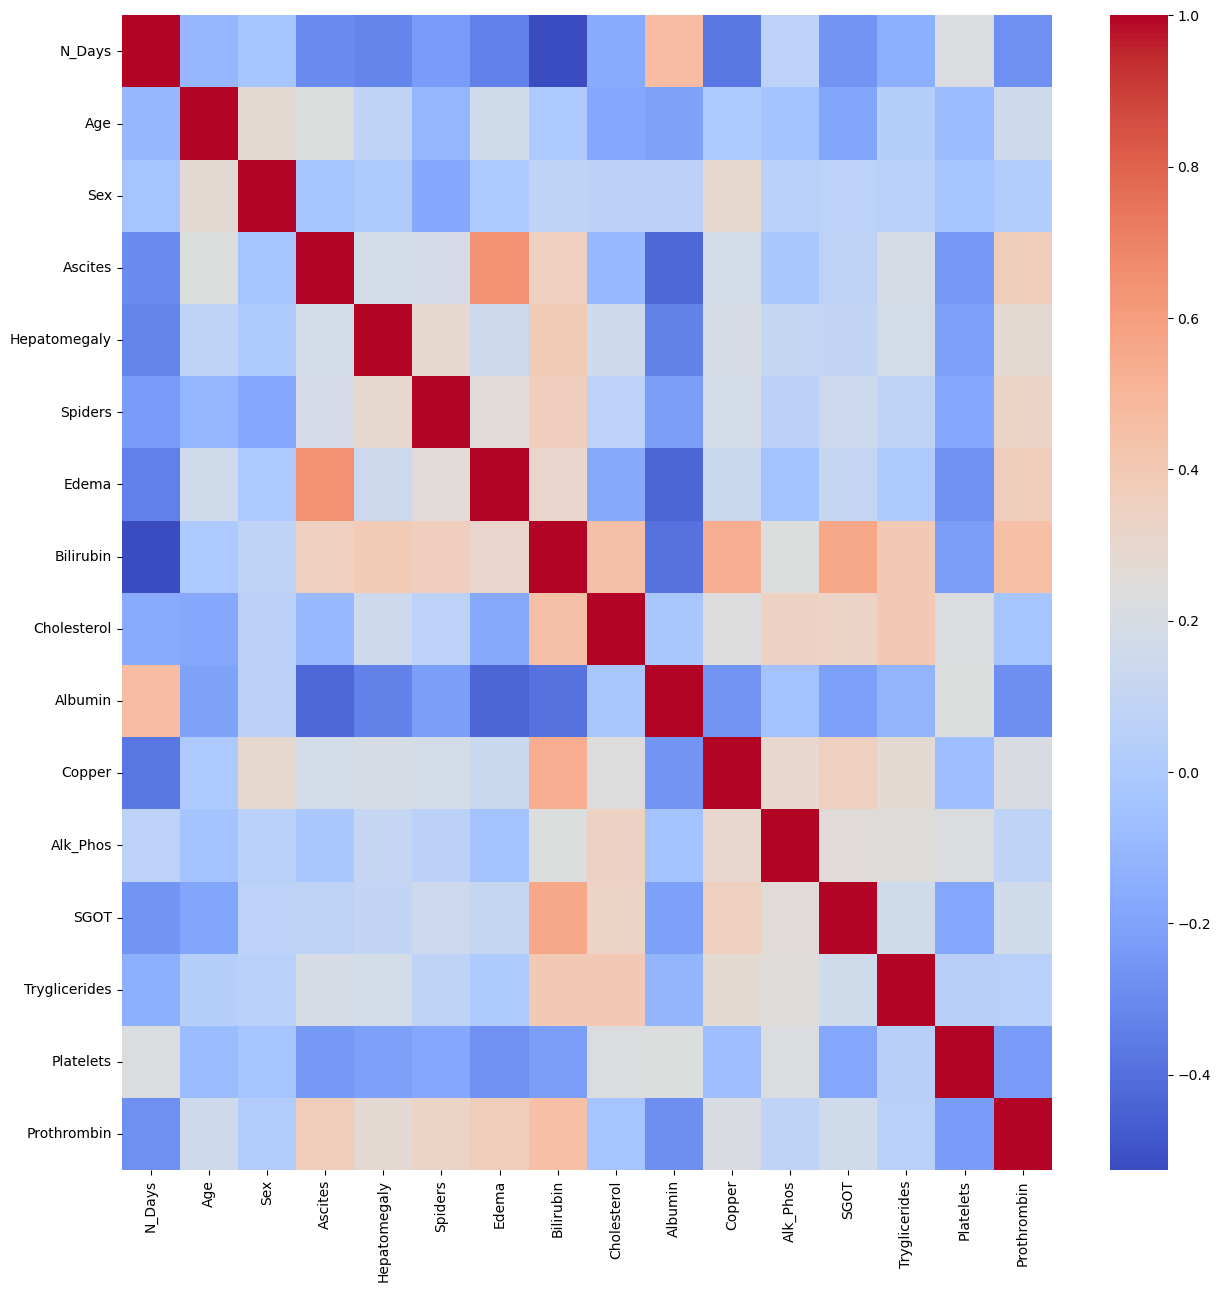

In [35]:
corr = X_train_tf.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

In [36]:
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

In [49]:
selector = SelectNonCollinear(correlation_threshold = 0.55, scoring = f_classif)

In [50]:
selector.fit(X_train_tf.values, y_train_tf.values)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
non_collinear = selector.get_support()
non_collinear[:5]

[True, True, True, True, True]

In [52]:
non_collinear.count(False)

2

In [53]:
non_collinear_series = pd.Series(selector.get_support(), index=X_train_tf.columns)
non_collinear_series

N_Days            True
Age               True
Sex               True
Ascites           True
Hepatomegaly      True
Spiders           True
Edema            False
Bilirubin         True
Cholesterol       True
Albumin           True
Copper            True
Alk_Phos          True
SGOT             False
Tryglicerides     True
Platelets         True
Prothrombin       True
dtype: bool

In [55]:
# Filter training data
training_data_to_keep = X_train_tf.values[:, non_collinear]
# Filter column names
columns = np.array(X_train_tf.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_tf.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

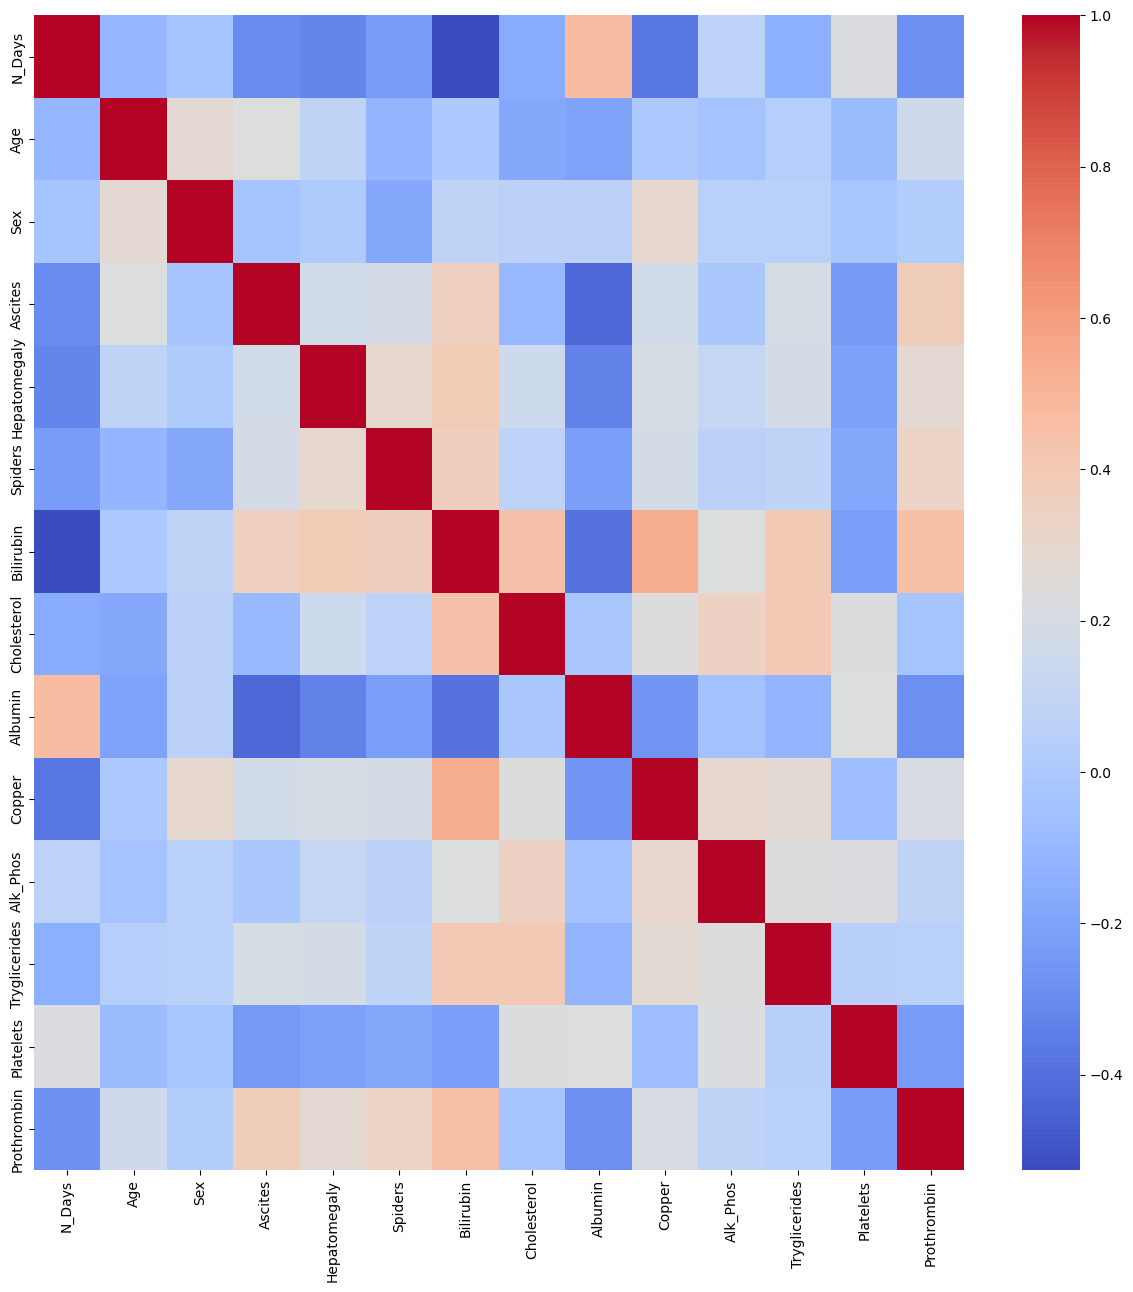

In [57]:
corr = X_train_no_corr.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00       141

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



/var/folders/zd/1wqdzm7d7d13shmcygx_4src0000gn/T/ipykernel_1457/1140985967.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train_no_corr, y_train_tf)


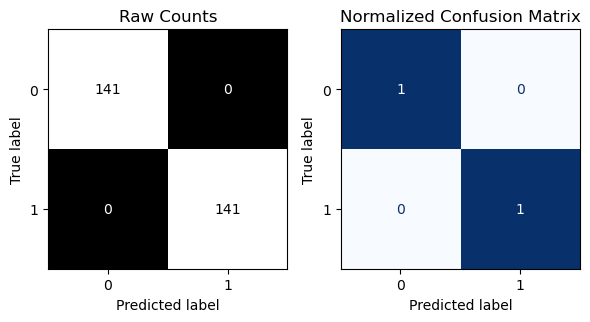


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        32
           1       0.85      0.87      0.86        46

    accuracy                           0.83        78
   macro avg       0.83      0.83      0.83        78
weighted avg       0.83      0.83      0.83        78



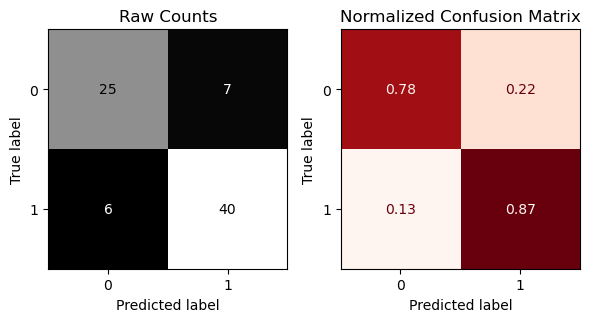

In [59]:
# Test the performance
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_no_corr, y_train_tf)
evaluate_classification(rf_clf, X_train_no_corr, y_train_tf, X_test_no_corr, y_test)